# Example of using Data Fusion Tools


* Use the Data Fusion Tools to process CPT data

* Use of Data Fusion Tools to combine CPT data and Resistivity measurements


## Set up environment

It is adviced to work with Python virtual environments. 

The main purpose of Python virtual environments is to create an isolated environment for Python projects. This means that each project can have its own dependencies, regardless of what dependencies every other project has. This avoids issues with packages dependencies.

The virtual environment should be installed and activated in order to run this tutorial.

To run this notebook jupiter notebook should be installed on the virtual enviroment.
To install the jupiter run:

`conda activate datafusiontools`

`conda install notebook`

To run the notebook run:

`jupyter notebook`


## Before starting

It is always good practice to make sure that the code is up-to-date.

You can update you code by running the following git command inside the project folder:

`git pull`


# Data sets

The datasets used in this tutorial are the following:
 - CPT
 - Resistivity

Load the data (available as pickle):

In [2]:
# load package
import pickle
# read pickle file
with open("../data/cpt_freshEM.pickle", "rb") as fi:
    [cpts, resistivity, ahn] = pickle.load(fi)
print(f"CPTs type: {type(cpts)}")
print(f"resistivity type: {type(resistivity)}")

CPTs type: <class 'dict'>
resistivity type: <class 'dict'>


## Inspect data

In [3]:
list(cpts.keys())[:10]

['CPT000000092677',
 'CPT000000092688',
 'CPT000000124814',
 'CPT000000092686',
 'CPT000000092658',
 'CPT000000092517',
 'CPT000000065140',
 'CPT000000092552',
 'CPT000000065215',
 'CPT000000092698']

In [4]:
cpts["CPT000000092677"].keys()

dict_keys(['coordinates', 'NAP', 'pwp', 'water', 'name', 'depth', 'tip', 'friction', 'friction_nb', 'IC', 'lithology'])

In [5]:
list(resistivity.keys())[:10]

['65184.0 394895.0',
 '65182.0 394891.0',
 '65182.0 394887.0',
 '65181.0 394883.0',
 '65181.0 394879.0',
 '65180.0 394875.0',
 '65180.0 394870.0',
 '65179.0 394866.0',
 '65178.0 394862.0',
 '65177.0 394858.0']

In [6]:
resistivity['65184.0 394895.0'].keys()

dict_keys(['coordinates', 'depth', 'NAP', 'resistivity'])

(393500.0, 396000.0)

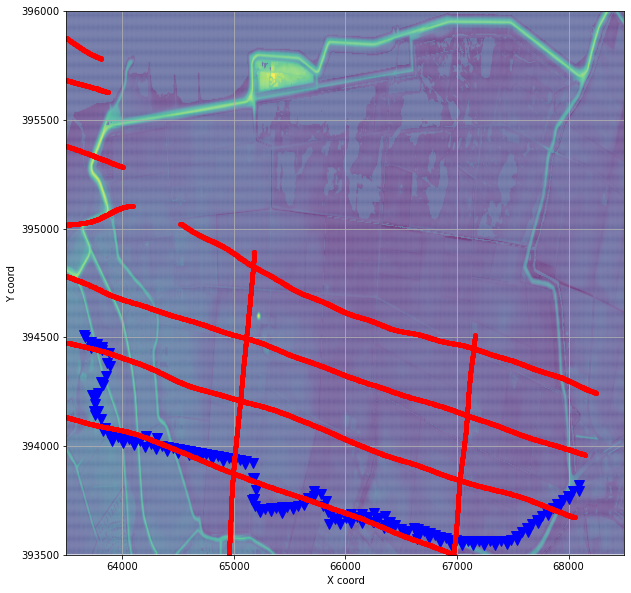

In [7]:
# import packages
import matplotlib.pylab as plt
import numpy as np

# plot data 
fig, ax = plt.subplots(figsize=(10, 10))

x_ahn3, y_ahn3 = np.meshgrid(ahn["x-coord"], ahn["y-coord"])
ax.pcolor(x_ahn3, y_ahn3, ahn["height"].T, shading='auto', alpha=1, linewidth=0, edgecolor=(1.0, 1.0, 1.0, 0.5))
    

for name, cpt in cpts.items():
    cpt_point = cpt["coordinates"]
    ax.plot(
        [cpt_point[0]], [cpt_point[1]], marker="v", markersize=10, color="blue"
    )
    
for name, res in resistivity.items():
    ax.plot(
        [res["coordinates"][0]],
        [res["coordinates"][1]],
        marker="o",
        markersize=4,
        color="red",
    )
    
ax.grid()
ax.set_xlabel("X coord", fontsize=10)
ax.set_ylabel("Y coord", fontsize=10)
ax.set_xlim(63500, 68500)
ax.set_ylim(393500, 396000)


### CPT data

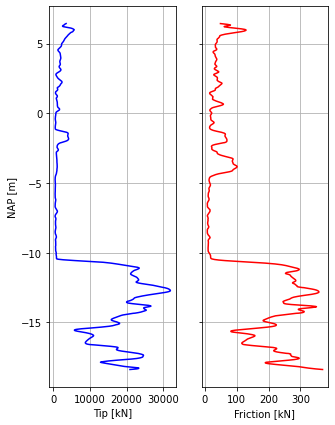

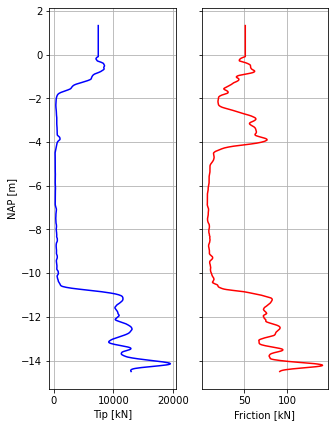

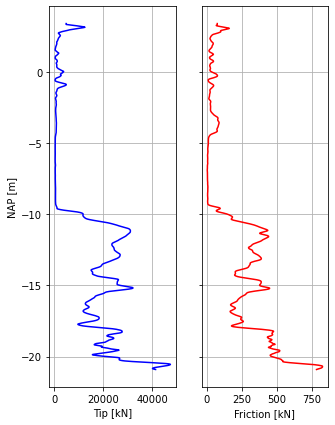

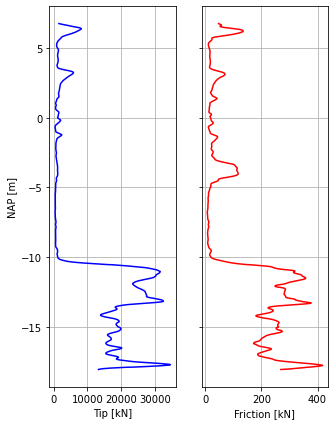

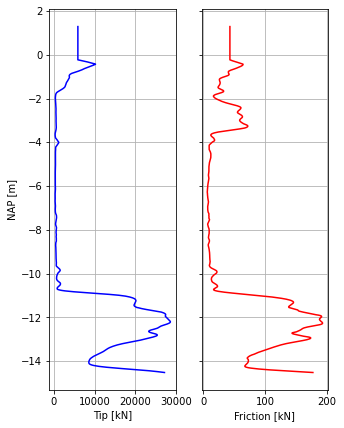

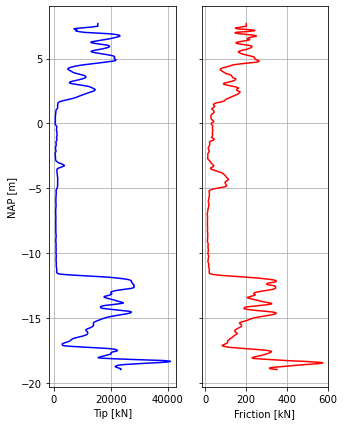

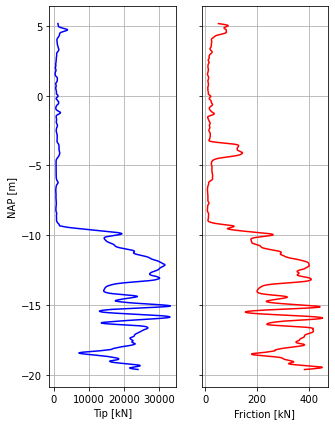

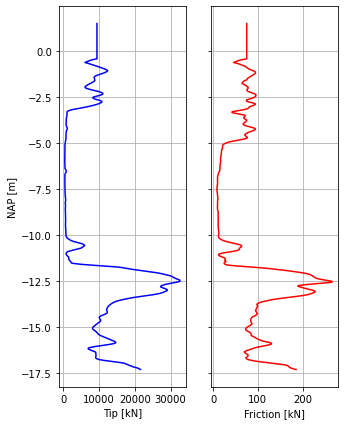

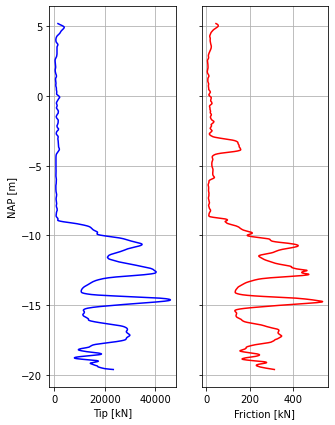

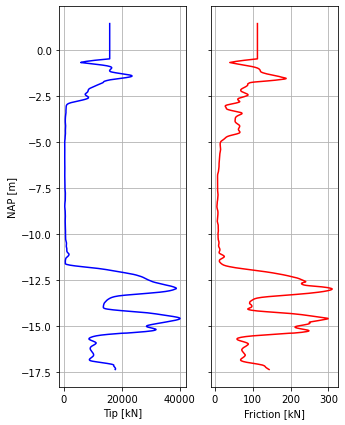

In [8]:
names = list(cpts.keys())

for name in names[:10]:
    fig, ax = plt.subplots(1, 2, figsize=(5, 7), sharey=True)
    ax[0].plot(cpts[name]["tip"], cpts[name]["NAP"], color="b")
    ax[1].plot(cpts[name]["friction"], cpts[name]["NAP"], color="r")
    ax[0].grid()
    ax[1].grid()
    ax[0].set_ylabel("NAP [m]")
    ax[0].set_xlabel("Tip [kN]")
    ax[1].set_xlabel("Friction [kN]")

### Resistivity data

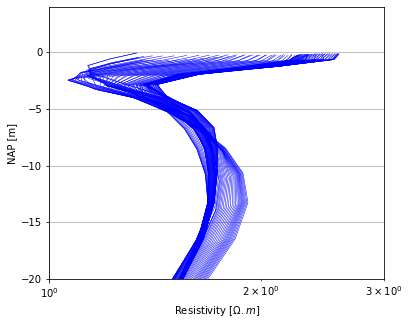

In [10]:
names = list(resistivity.keys())
fig, ax = plt.subplots(figsize=(6, 5))
for name in names[:100]:
    ax.plot(resistivity[name]["resistivity"], resistivity[name]["NAP"], color="b", linewidth=0.5)
ax.set_xscale('log')
ax.set_xlabel("Resistivity [$\Omega.m$]")
ax.set_ylabel("NAP [m]")
ax.set_ylim(bottom=-20)
ax.set_xlim(1, 3)
ax.grid()


## Example 1 : CPT interpretation

### Predict IC of CPTs based on tip and friction

In [11]:
# import data fusion packages
from datafusiontools._core.data_input import Data, Variable, Geometry
from datafusiontools._core.utils import CreateInputsML
from datafusiontools.machine_learning.mpl import MPL
from datafusiontools.machine_learning.random_forest import RandomForest
import datafusiontools.machine_learning.enumeration_classes as class_enums

# import system packages
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d
from pathlib import Path
import itertools

#### Create features

To create the features there is the `CreateInputsML` class.

The input data needs to be defined as `Variables` (with `label` and `values`).

The features are build as `Data class` whic consists of a collection of `Variables`.



In [12]:
# create the feature list
create_features = CreateInputsML()

# for every CPT collect the data and assign it to the features
for c in cpts.keys():
    # create Variables for CPT data
    depth = Variable(label="depth", value=np.array(cpts[c].get("NAP")))
    tip = Variable(label="tip", value=np.array(cpts[c].get("tip")))
    friction = Variable(label="friction", value=np.array(cpts[c].get("friction")))
    IC = Variable(label="IC", value=np.array(cpts[c].get("IC")))

    # Create data class for the CPT
    cpt = Data(location=Geometry(x=cpts[c]["coordinates"][0], y=cpts[c]["coordinates"][1], z=0),
               variables=[tip, friction, IC],
               independent_variable=depth
               )

    # add features and targets
    create_features.add_features(cpt, ["tip", "friction"], use_independent_variable=True)
    create_features.add_targets(cpt, ["IC"])

To perform the training the data can be divided into training and validation

In [13]:
# divide the data into training and validation
create_features.split_train_test_data(train_percentage=0.7)
training_data = create_features.get_features_train(flatten=False)
target_data = create_features.get_targets_train(flatten=False)
validation_training = create_features.get_features_test(flatten=False)
validation_target = create_features.get_targets_test(flatten=False)


#### Perform training

The training can be perform for any of the available methods. The methods are interchangeable. 

In [14]:
nn = MPL(
    classification=False,
    nb_hidden_layers=4,
    nb_neurons=[8, 8, 8, 8],
    activation_fct=class_enums.ActivationFunctions.relu,
    optimizer=class_enums.Optimizer.Adam,
    loss=class_enums.LossFunctions.mean_squared_error,
    epochs=200,
    batch=500,
    regularisation=0,
)

# nn = RandomForest(
#     classification=False,
#     n_estimator=np.array([10]),
#     max_depth=np.array([10]),
# )

# Train with flat shape
nn.train(
    training_data,
    target_data,
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
rescaling (Rescaling)        (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9     

227/227 [==============================] - 1s 2ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0944A: 0s - loss: 0.0176 - mse: 0.0176 - mae: 0.
Epoch 59/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0947
Epoch 60/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0942
Epoch 61/200
227/227 [==============================] - 1s 2ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0942A: 0s - loss: 0.0176 - mse: 0.0176 - mae:
Epoch 62/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0939
Epoch 63/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0938A: 0s - loss: 0.0176 - mse: 0.0176 - mae: 0.093
Epoch 64/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.0935
Epoch 65/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0175 - mse: 0.0175 - mae: 

227/227 [==============================] - 1s 4ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0874
Epoch 125/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0874
Epoch 126/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0868
Epoch 127/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0869
Epoch 128/200
227/227 [==============================] - 1s 2ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0869
Epoch 129/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0869
Epoch 130/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0866A: 0s - loss: 0.0163 - mse: 0.0163 - mae: 0.08
Epoch 131/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0869
Epoch 132/200
227/227 [==============================] - 0s 2ms/step - l

227/227 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0842
Epoch 193/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0839
Epoch 194/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0838A: 0s - loss: 0.0157 - mse: 0.0157 - mae: 0.0
Epoch 195/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0838
Epoch 196/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0839A: 0s - loss: 0.0157 - mse: 0.0157 - mae: 0.
Epoch 197/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0835
Epoch 198/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0834
Epoch 199/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0836
Epoch 200/200
3538/3538 [====

#### Assessment of performance

In [15]:
nn.plot_cost_function(output_folder=Path("./NN"))
nn.predict(validation_training)
nn.plot_fitted_line(validation_target, output_folder=Path("./NN"))

### Predict IC of CPTs based on tip, friction and position
#### Create features

In [18]:
# create the feature list
create_features = CreateInputsML()

# for every CPT collect the data and assign it to the features
for c in cpts.keys():
    # create Variables for CPT data
    depth = Variable(label="depth", value=np.array(cpts[c].get("NAP")))
    tip = Variable(label="tip", value=np.array(cpts[c].get("tip")))
    friction = Variable(label="friction", value=np.array(cpts[c].get("friction")))
    IC = Variable(label="IC", value=np.array(cpts[c].get("IC")))

    # Create data class for the CPT
    cpt = Data(location=Geometry(x=cpts[c]["coordinates"][0], y=cpts[c]["coordinates"][1], z=0),
               variables=[tip, friction, IC],
               independent_variable=depth
               )

    # add features and targets
    create_features.add_features(cpt, ["tip", "friction"],
                                 use_location_as_input=[True, True, False], 
                                 use_independent_variable=True)
    create_features.add_targets(cpt, ["IC"])


# divide the data into training and validation
create_features.split_train_test_data(train_percentage=0.7)
training_data = create_features.get_features_train(flatten=False)
target_data = create_features.get_targets_train(flatten=False)
validation_training = create_features.get_features_test(flatten=False)
validation_target = create_features.get_targets_test(flatten=False)

#### Perform training and assessment

In [19]:
nn = MPL(
    classification=False,
    nb_hidden_layers=4,
    nb_neurons=[8, 8, 8, 8],
    activation_fct=class_enums.ActivationFunctions.relu,
    optimizer=class_enums.Optimizer.Adam,
    loss=class_enums.LossFunctions.mean_squared_error,
    epochs=200,
    batch=500,
    regularisation=0,
)

# Train with flat shape
nn.train(
    training_data,
    target_data,
)
nn.plot_cost_function(output_folder=Path("./NN_with_coords"))
nn.predict(validation_training)
nn.plot_fitted_line(validation_target, output_folder=Path("./NN_with_coords"))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 48        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9   

230/230 [==============================] - 0s 2ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.1006A: 0s - loss: 0.0189 - mse: 0.0189 - mae: 0.1 - ETA: 0s - loss: 0.0188 - mse: 0.0188 - mae: 0.10
Epoch 60/200
230/230 [==============================] - 1s 3ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1001A: 0s - loss: 0.0186 - mse: 0.0186 - mae: 
Epoch 61/200
230/230 [==============================] - 1s 3ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0999
Epoch 62/200
230/230 [==============================] - 1s 3ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0998
Epoch 63/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1001
Epoch 64/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1000
Epoch 65/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0998A: 0s - loss: 0.0186 - mse: 0.0186 - mae: 
Epoch 66/200
230/230 [==============================] - 

230/230 [==============================] - 1s 2ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0891
Epoch 126/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0888
Epoch 127/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0887
Epoch 128/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0887
Epoch 129/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0885
Epoch 130/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0882
Epoch 131/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0879
Epoch 132/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0879
Epoch 133/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0877
Epoch 

230/230 [==============================] - 1s 2ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0840
Epoch 196/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0836A: 0s - loss: 0.0149 - mse: 0.0149 - mae
Epoch 197/200
230/230 [==============================] - 1s 2ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0835A: 0s - loss: 0.0148 - mse: 0.0148 - mae: 0.0
Epoch 198/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0837
Epoch 199/200
230/230 [==============================] - 0s 2ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0843
Epoch 200/200
3593/3593 [==============================] - 6s 2ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0817- ETA: 1s - los
mse: 0.01


### Predict lithology of CPTs based on tip and friction

Classification problem

#### Create features

In [20]:
# create the feature list
create_features = CreateInputsML()

# for every CPT collect the data and assign it to the features
for c in cpts.keys():
    # create Variables for CPT data
    depth = Variable(label="depth", value=np.array(cpts[c].get("NAP")))
    tip = Variable(label="tip", value=np.array(cpts[c].get("tip")))
    friction = Variable(label="friction", value=np.array(cpts[c].get("friction")))
    lithology = Variable(label="lithology", value=np.array(cpts[c].get("lithology")))

    # Create data class for the CPT
    cpt = Data(location=Geometry(x=cpts[c]["coordinates"][0], y=cpts[c]["coordinates"][1], z=0),
               variables=[tip, friction, lithology],
               independent_variable=depth
               )

    # add features and targets
    create_features.add_features(cpt, ["tip", "friction"], use_independent_variable=True)
    create_features.add_targets(cpt, ["lithology"])


# divide the data into training and validation
create_features.split_train_test_data(train_percentage=0.7)
training_data = create_features.get_features_train(flatten=False)
target_data = create_features.get_targets_train(flatten=False)
validation_training = create_features.get_features_test(flatten=False)
validation_target = create_features.get_targets_test(flatten=False)

#### Perform training and assessment

In [21]:
nn = MPL(
    classification=True,
    nb_hidden_layers=4,
    nb_neurons=[8, 8, 8, 8],
    activation_fct=class_enums.ActivationFunctions.sigmoid,
    optimizer=class_enums.Optimizer.Adam,
    loss=class_enums.LossFunctions.binary_crossentropy,
    epochs=100,
    batch=500,
    regularisation=0,
)

# Train with flat shape
nn.train(
    training_data,
    target_data,
)
nn.plot_cost_function(output_folder=Path("./NN_classification"))
nn.predict(validation_training)
nn.plot_confusion(validation_target, output_folder=Path("./NN_classification"))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 3)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 32        
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 81  

230/230 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 0.8463: 0s - loss: 0.0757 - ac
Epoch 66/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0745 - accuracy: 0.8470
Epoch 67/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0735 - accuracy: 0.8473
Epoch 68/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.8536
Epoch 69/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.8658: 0s - loss: 0.0725 - accu
Epoch 70/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.8671: 0s - loss: 0.0705 - accuracy
Epoch 71/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.8672
Epoch 72/100
230/230 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.86 - 0s 2ms/step - loss: 0.0690 - accuracy: 0.8668
Epoch 73/100
230/230 [==============================] - 0s 2ms/step - loss:

## Example 2 : Data Fusion: combination of CPT / Resistivity

The objective is improve the 3D subsoil schematisation. The CPT tests are assumed to be the most accurate test to determine the soil schematisation. However, CPT tests are not continuously available. Resistivity measurements have greater spatial coverage (with lower vertical resolution).

<img src="static/data_overview.png" width="400" height="790">


For the feature the following strategy was followed:
- For each CPT 
  * Compute IC value
  * Collect Resistivity within the radius R
  * Average the resistivity values

- Create Feature Space
  * Input features: geospatial location, resistivity
  * Target value: IC

- Train ML

### Parameters

Radius R

Number of CPTs to perform a validation


In [22]:
# reference radius
ref_dist = 50

In [23]:
# define number of CPT to validate
nb_cpts_val = 10

### Create features 

In [26]:
# create the feature list
create_features = CreateInputsML()

# create a list of all CPTs
cpts_names = list(cpts.keys())
# number of CPTs for the analysis
nb_cpts = 0 

for c in cpts_names[nb_cpts_val:]:

    # find resistivity points that are within the radius ref_dist
    idx = [r for r in resistivity 
           if np.linalg.norm(np.array(resistivity[r]["coordinates"]) - np.array(cpts[c]["coordinates"])) < ref_dist]
    if not idx:
        continue
    
    # update count of number of cpts
    nb_cpts += 1
    
    # collect mean values around radius
    resistivity_mean = np.mean([resistivity[i]["resistivity"] for i in idx], axis=0)
    resistivity_nap = np.mean([resistivity[i]["NAP"] for i in idx], axis=0)

    # interpolate the resistivity values at the same depths as the CPT
    interp = interp1d(resistivity_nap, resistivity_mean, fill_value=(resistivity_mean[0], resistivity_mean[-1]), bounds_error=False)
    res_cpt = interp(cpts[c]["NAP"])

    # create Variables for CPT data and Resistivity
    resistivity_var = Variable(label="resistivity", value=np.array(res_cpt))
    resistivity_nap_var = Variable(label="depth", value=np.array(cpts[c]["NAP"]))
    cpt_ic_var = Variable(label="IC", value=np.array(cpts[c]["IC"]))
    cpt_nap_var = Variable(label="depth", value=np.array(cpts[c]["NAP"]))

    # Create data class for the Resistivity
    resist = Data(location=Geometry(x=cpts[c]["coordinates"][0], y=cpts[c]["coordinates"][1], z=0),
                  variables=[resistivity_var],
                  independent_variable=resistivity_nap_var
                  )

    # Create data class for the CPT
    cpt = Data(location=Geometry(x=cpts[c]["coordinates"][0], y=cpts[c]["coordinates"][1], z=0),
               variables=[cpt_ic_var],
               independent_variable=cpt_nap_var
               )

    create_features.add_features(resist, ["resistivity"], 
                                 use_location_as_input=[True, True, False], 
                                 use_independent_variable=True)
    create_features.add_targets(cpt, ["IC"])

# divide the data into training and validation
create_features.split_train_test_data(train_percentage=0.7)
training_data = create_features.get_features_train(flatten=False)
target_data = create_features.get_targets_train(flatten=False)
validation_training = create_features.get_features_test(flatten=False)
validation_target = create_features.get_targets_test(flatten=False)

print(f"Total number of CPTs in the analysis: {nb_cpts}")

Total number of CPTs in the analysis: 89


### Perform training

In [27]:
nn = RandomForest(
    classification=False,
    n_estimator=np.array([10]),
    max_depth=np.array([20]),
)

# Train with flat shape
nn.train(
    training_data,
    target_data,
)
nn.predict(validation_training)

{'max_depth': 20, 'n_estimators': 10}
RMSE of training: 0.03


### Evaluate the performance against the validation CPTs 

The validation CPTs have not been used during training

In [28]:
validation = []
names_validation = []

# collect the 
for c in cpts_names[:nb_cpts_val]:
    
    # find resistivity points that are within the radius ref_dist
    idx = [r for r in resistivity 
           if np.linalg.norm(np.array(resistivity[r]["coordinates"]) - np.array(cpts[c]["coordinates"])) < ref_dist]
    if not idx:
        continue
    
    # append the name of CPT
    names_validation.append(c)
    
    # collect mean values around radius
    resistivity_mean = np.mean([resistivity[i]["resistivity"] for i in idx], axis=0)
    resistivity_nap = np.mean([resistivity[i]["NAP"] for i in idx], axis=0)
    
    # interpolate the resistivity values at the same depths as the CPT
    interp = interp1d(resistivity_nap, resistivity_mean, fill_value=(resistivity_mean[0], resistivity_mean[-1]), bounds_error=False)
    res_cpt = interp(cpts[c]["NAP"])
    
    # append to the validation dataset
    validation.extend(list(zip(res_cpt, cpts[c]["NAP"],
                                   itertools.repeat(cpts[c]["coordinates"][0]), itertools.repeat(cpts[c]["coordinates"][1]))))
    


Compare the IC of the validation CPT against the IC from ML

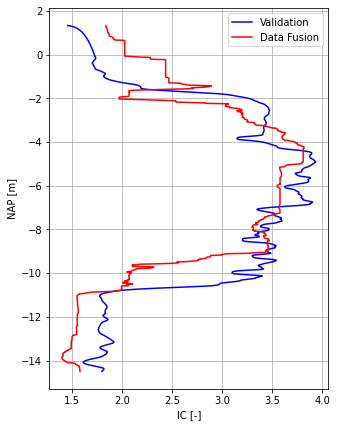

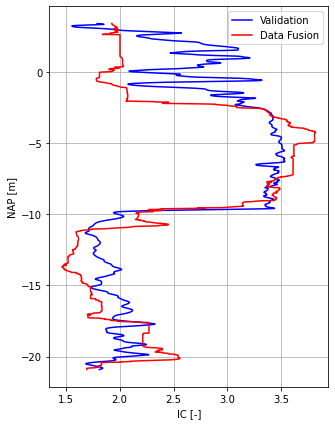

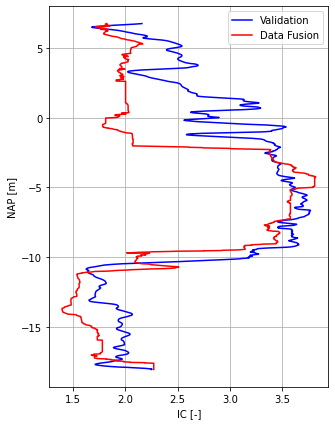

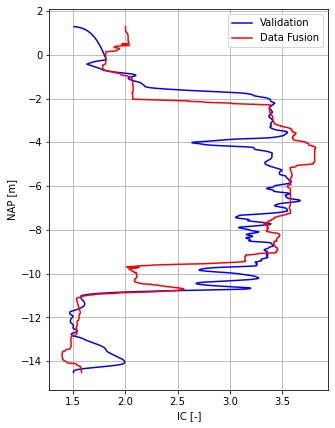

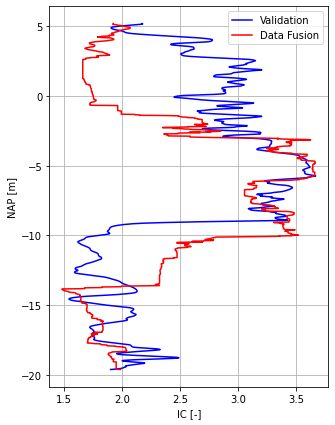

In [29]:
# transform into numpy array
validation = np.array(validation)

# apply the ML to the new validation dataset
nn.predict(validation)

# plot for every CPT
for c in names_validation:
    idx = np.where((cpts[c]["coordinates"][0] == validation[:, 2]) & (cpts[c]["coordinates"][1] == validation[:, 3]))[0]

    fig, ax = plt.subplots(figsize=(5, 7))
    ax.plot(cpts[c]["IC"], cpts[c]["NAP"], label="Validation", color="b")
    ax.plot(nn.prediction[idx], validation[idx, 1], label="Data Fusion", color="r")
    ax.set_xlabel("IC [-]")
    ax.set_ylabel("NAP [m]")
    ax.grid()
    ax.legend()

## Apply the Data Fusion method to all the resistivity values

Define maximum depth of the resistivity

In [30]:
max_depth = -20

Create the dataset with the full resistivity data

In [31]:
full_3D = []
# for all resistivity points
for r in resistivity:
    # find indexes where the depth is greater than max_depth
    idx = np.where(np.array(resistivity[r]["NAP"]) <= max_depth)[0][0]
    # append
    full_3D.extend(list(zip(np.array(resistivity[r]["resistivity"])[:idx], np.array(resistivity[r]["NAP"])[:idx],
                                   itertools.repeat(resistivity[r]["coordinates"][0]), itertools.repeat(resistivity[r]["coordinates"][1]))))

# convert to numpy
full_3D = np.array(full_3D)
# apply ML
nn.predict(full_3D)


Visualise the results

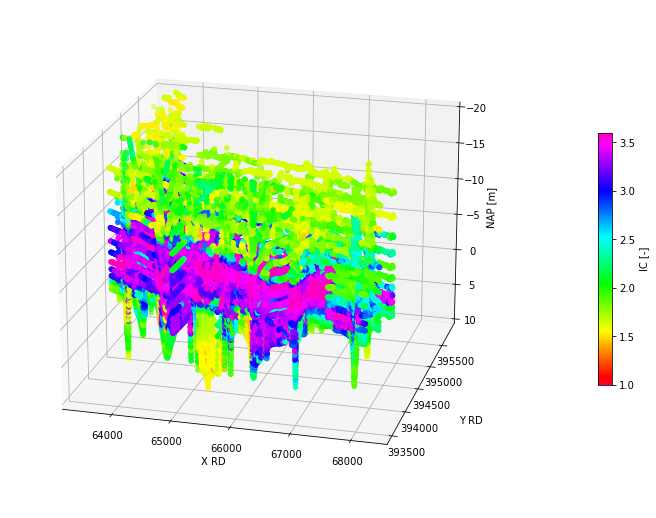

In [32]:
# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')    
ax.set_position([-0.12, 0.0, 1, 1])
ax.view_init(20, -75)

# plot data
im = ax.scatter(full_3D[:, 2], full_3D[:, 3], full_3D[:, 1], c=nn.prediction,
                vmin=1, vmax=3.6, cmap="gist_rainbow")

# axis labels
ax.set_xlabel("X RD", fontsize=10)
ax.set_ylabel("Y RD", labelpad=20, fontsize=10)
ax.set_zlabel("NAP [m]", fontsize=10)
ax.set_zlim(10, -20)

# legend
cax = plt.axes([0.85, 0.25, 0.02, 0.5])
cbar = plt.colorbar(im, cax=cax, fraction=0.1, pad=0.01)
cbar.set_label("IC [-]", fontsize=10)
